In [6]:
import pandas as pd
films = pd.read_csv('LDA.csv')
films.head(1)
# import spacy
# !python -m spacy download fr_core_news_sm # Donwload spacy model

,url,note,title,author,date,text,genre,realisateur,acteurs,moviedate
0,https://www.telerama.fr/cinema/films/le-temps-...,r Très Bien,Le Temps retrouvé,Pierre Murat,Publié le 13/12/2022,Avec un casting royal réunissant John Malkovic...,Comédie dramatique,Réalisé par Raoul Ruiz,"avec Marcello Mazzarella, Catherine Deneuve, ...",Comédie dramatique (2h49) - 1999 - France


In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from gensim import corpora, models
import matplotlib.pyplot as plt
import re
import spacy

# DRO MANUALLY
drop_list = ['film', 'genre','']

# Ensure that NLTK stopwords are downloaded
nltk.download('stopwords')

!python -m spacy download fr_core_news_sm > /dev/null 2>&1
nlp = spacy.load('fr_core_news_sm')

# Load a better stopword list
!wget https://raw.githubusercontent.com/KillianJK/Liste-stopwords-francais-XVIe/main/Liste%20stopwords%20fran%C3%A7ais%20XVIe.txt
extra_stopwords_file = 'Liste stopwords français XVIe.txt'

with open(extra_stopwords_file, 'r', encoding='utf-8') as file:
    extended_stopwords = file.read().splitlines()

repunc_extended_stopwords = [re.sub(r'[^\w\s]', '', word) for word in extended_stopwords]

# Read the data
films = pd.read_csv('LDA.csv')
films['year'] = films['moviedate'].str.extract(r'(\d{4})')

# Preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = str(text)
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenize and lemmatize
    words = text.split()
    words = [word for word in words if word not in drop_list]

    # Combine the default NLTK French stopwords with your extended list
    all_stopwords = set(stopwords.words('french')).union(set(extended_stopwords)).union(set(repunc_extended_stopwords))

    # Remove stopwords and perform stemming
    stemmer = FrenchStemmer()
    words = [stemmer.stem(word) for word in words if word not in all_stopwords]

    return words

# Exteact year from date
films['year'] = films['moviedate'].str.extract(r'(\d{4})')
films = films.dropna(subset=['year'])
films['year'] = films['year'].astype(int)

# compute the start year for each 10-year
films['10_year_group'] = (films['year'] // 10 - 1) * 10

# Group by every 10 years
grouped_films = films.groupby('10_year_group')

# LDA_models
lda_models_by_year = {}

corpora_by_year = {}
dictionaries_by_year = {}
from collections import defaultdict
top_words_by_year = defaultdict(list)

for year, group in grouped_films:
    # Preprocess
    group['processed_text'] = group['text'].apply(preprocess_text)

    # Create dictionary and corpus
    dictionary = corpora.Dictionary(group['processed_text'])
    corpus = [dictionary.doc2bow(text) for text in group['processed_text']]

    # Save dictionary and corpora
    dictionaries_by_year[year] = dictionary
    corpora_by_year[year] = corpus

    # Fit LDA
    lda_model = models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=10)
    lda_models_by_year[year] = lda_model

    # Extract top 10 words for each topic
    for topic_id, topic in lda_model.show_topics(num_topics=10, num_words=10, formatted=False):
        for word, weight in topic:
            top_words_by_year[year].append((word, weight))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--2024-02-20 00:13:36--  https://raw.githubusercontent.com/KillianJK/Liste-stopwords-francais-XVIe/main/Liste%20stopwords%20fran%C3%A7ais%20XVIe.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703 (4.6K) [text/plain]
Saving to: ‘Liste stopwords français XVIe.txt.1’

Liste stopwords fra 100%[===================>]   4.59K  --.-KB/s    in 0s      

2024-02-20 00:13:37 (51.3 MB/s) - ‘Liste stopwords français XVIe.txt.1’ saved [4703/4703]



<ipython-input-7-7d67c54d60b3>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  films['year'] = films['year'].astype(int)
<ipython-input-7-7d67c54d60b3>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  films['10_year_group'] = (films['year'] // 10 - 1) * 10


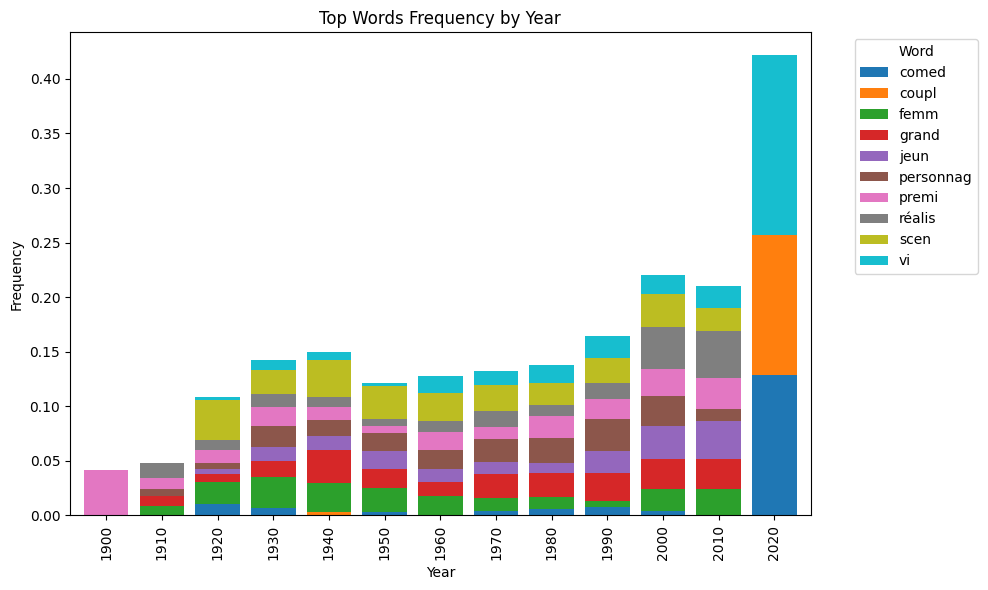

In [8]:
data_for_plotting = []
for year, words in top_words_by_year.items():
    for word, weight in words:
        data_for_plotting.append((year, word, weight))

# Create DataFrame
df = pd.DataFrame(data_for_plotting, columns=['Year', 'Word', 'Frequency'])

# Aggregate data to calculate the total frequency of each word per year
df_aggregated = df.groupby(['Year', 'Word']).sum().reset_index()

# Calculate the total frequency of each word and select the top ten most frequent words
top_words = df_aggregated.groupby('Word').sum().sort_values(by='Frequency', ascending=False).head(10).reset_index()['Word']

# Filter the data to only include the top ten most frequent words
df_filtered = df_aggregated[df_aggregated['Word'].isin(top_words)]

# To create a stacked bar plot, we need to transform the data to show the frequency of each word per year
pivot_df = df_filtered.pivot(index='Year', columns='Word', values='Frequency').fillna(0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8)

plt.title('Top Words Frequency by Year')
plt.ylabel('Frequency')
plt.xlabel('Year')
plt.legend(title='Word', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [9]:
pd.set_option('display.max_rows', None)

# Initialize an empty DataFrame
all_years_df = pd.DataFrame()

# Assume lda_models_by_year is our dictionary that maps years to LDA models
for year, lda_model in lda_models_by_year.items():
    # Get the description of each topic in the model
    topics_words = lda_model.print_topics(num_words=10)  # Assume we get the top 10 words for each topic

    # Prepare data to create the table
    data = {}
    for num, topic in topics_words:
        topic_words = topic.split('+')
        # Keep only the words, excluding the weights
        words = [word.split('*')[1].strip().replace('"', '') for word in topic_words]
        data[f"Topic {num+1}"] = words

    # Create DataFrame for the current year
    df = pd.DataFrame(data)
    print(year, '\n', df)
    df['Year'] = year  # Add the year column

    # Append the current year's DataFrame to the overall DataFrame
    all_years_df = pd.concat([all_years_df, df], ignore_index=True)

# Finally, we have a DataFrame containing data for all years
# all_years_df


1890 
    Topic 1   Topic 2   Topic 3      Topic 4      Topic 5  Topic 6  Topic 7  \
0    voyag    mélies    mélies         imag       mélies    voyag     imag   
1     imag      imag     voyag        voyag        voyag     imag    numer   
2   mélies     voyag      imag       mélies         imag   mélies    siecl   
3    numer    réalit     siecl      restaur      restaur    numer   mélies   
4    siecl     numer    réalit       réalit        siecl   réalit    voyag   
5   réalit     siecl   restaur        numer       réalit    siecl  restaur   
6  restaur   restaur     numer        siecl        numer  restaur   réalit   
7    objet      muet       gen      dynamis  documentair     vaut      aut   
8     vaut    lillus      yeux  trompeloeil       lespac     eric     vaut   
9    vieux  manifest  temporel      ferencz         lang  poétiqu    cinem   

      Topic 8        Topic 9   Topic 10  
0        imag   planètevisag      siecl  
1      mélies          plein     mélies  
2       

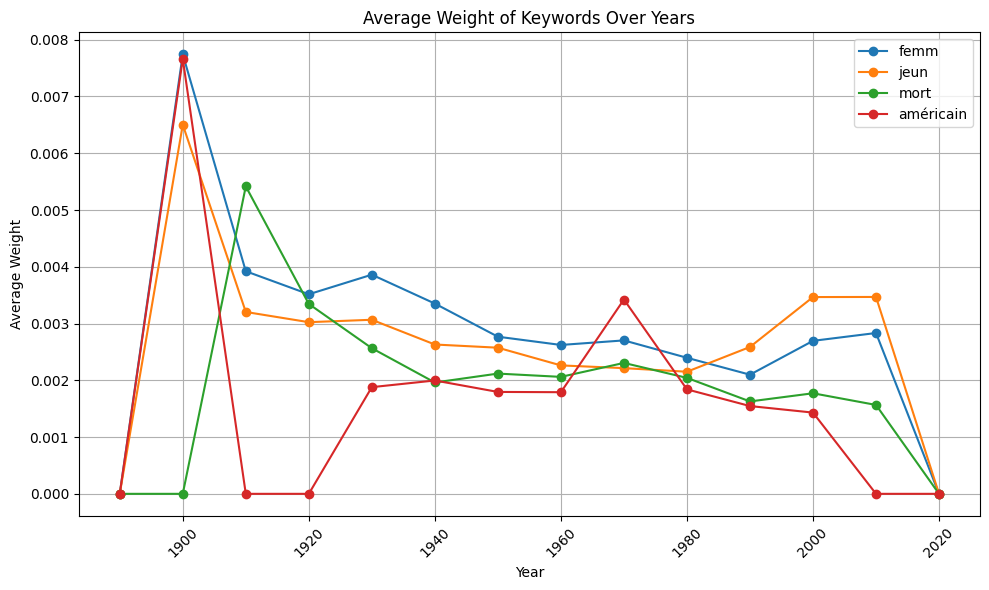

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Specify a set of keywords of interest
keywords = ['femm', 'jeun', 'mort', 'américain']

# Initialize a dictionary to store the average weight of each keyword for each year
keywords_yearly_avg_weight = {keyword: [] for keyword in keywords}
years = []

# Iterate through each year and the corresponding LDA model
for year, lda_model in lda_models_by_year.items():
    years.append(year)
    # For each keyword, get the weight across all topics and calculate the average
    for keyword in keywords:
        total_weight = 0
        total_count = 0
        # Iterate through all topics
        for topic_id in range(lda_model.num_topics):
            # Get the words and their weights for this topic
            topic_words = lda_model.show_topic(topic_id, topn=50)  # Check the top 50 words
            # Iterate through topic words to find our keyword
            for word, weight in topic_words:
                if word == keyword:
                    total_weight += weight
                    total_count += 1
                    break  # Exit loop once keyword is found
        # Calculate the average weight and save it
        avg_weight = total_weight / total_count if total_count > 0 else 0
        keywords_yearly_avg_weight[keyword].append(avg_weight)

# Convert data to DataFrame
df_keywords = pd.DataFrame(keywords_yearly_avg_weight, index=years)

# Plot the data
plt.figure(figsize=(10, 6))
for keyword in keywords:
    plt.plot(df_keywords.index, df_keywords[keyword], marker='o', label=keyword)

plt.title('Average Weight of Keywords Over Years')
plt.xlabel('Year')
plt.ylabel('Average Weight')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# ! pip install pickle
! pip install pyLDAvis  > /dev/null 2>&1
! pip install "pandas<2.0.0"  > /dev/null 2>&1 # install this if LDAvis_prepared gives error

import os
import pickle

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import os

pyLDAvis.enable_notebook()

os.makedirs('./final_result', exist_ok=True)

num_topics = 10

for year, lda_model in lda_models_by_year.items():
    # Get saved corpus and dictionary
    corpus = corpora_by_year[year]
    dictionary = dictionaries_by_year[year]

    # LDA data
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)

    # file path for ldavis
    ldavis_filepath = os.path.join('./final_result/ldavis_prepared_' + str(year) + '_'+ str(num_topics))

    # Saving
    with open(ldavis_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

    # Visualization
    print(f'Year: {year}')
    pyLDAvis.display(LDAvis_prepared)


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1890


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1900


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1910


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1920


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1930


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1940


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1950


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1960


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1970


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1980


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 1990


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 2000


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Year: 2010
Year: 2020


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [13]:
year = 1940
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
year = 1950
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
year = 1960
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
year = 1970
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
year = 1980
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
year = 1990
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
year = 2000
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
year = 2010
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
year = 2020
pyLDAvis.display(pickle.load(open(f'./final_result/ldavis_prepared_{year}_10', 'rb')))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
